# Emotion Classification Model
Tommaso Salvatori and Valentin Brekke.

## Setup

In [ ]:
# import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchsummary import summary

import torchvision
from torchvision import datasets, transforms
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# mount Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# clone repository
!git clone https://github.com/valentin-brekke/emotion_artistic_augmentation.git

fatal: destination path 'emotion_artistic_augmentation' already exists and is not an empty directory.


In [ ]:
# define data path
data_path = '/content/emotion_artistic_augmentation/data/emotionface'

In [ ]:
# define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# load datasets
train_dataset = datasets.ImageFolder(root=data_path + '/train',
                                     transform=transform)
test_dataset = datasets.ImageFolder(root=data_path + '/test',
                                    transform=transform)

In [ ]:
# extract labels
classes = train_dataset.classes
print(classes)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# count class values
class_counts = Counter(train_dataset.targets)

# find the class with the highest count
majority_class = class_counts.most_common(1)[0][0]

print(f"The majority class is: {majority_class}")

The majority class is: 3


In [ ]:
total_samples = len(train_dataset)

# calculate the percentage of values belonging to the majority class
majority_class_count = class_counts[majority_class]
percentage_majority_class = (majority_class_count / total_samples) * 100

print(f"The majority class ({majority_class}) constitutes {percentage_majority_class:.2f}% of the dataset.")

The majority class (3) constitutes 25.13% of the dataset.


In [ ]:
# split into train and validation sets
total_train = len(train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# function to show images
def imshow(images, labels, classes):
    images = images / 2 + 0.5     # unnormalize
    npimages = images.numpy()

    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    axes = axes.flatten()     # flatten to a list

    for idx, ax in enumerate(axes):
        # convert to mpl format
        img = np.transpose(npimages[idx], (1, 2, 0))
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(classes[labels[idx]])

    plt.tight_layout()
    plt.show()

In [ ]:
# get random batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

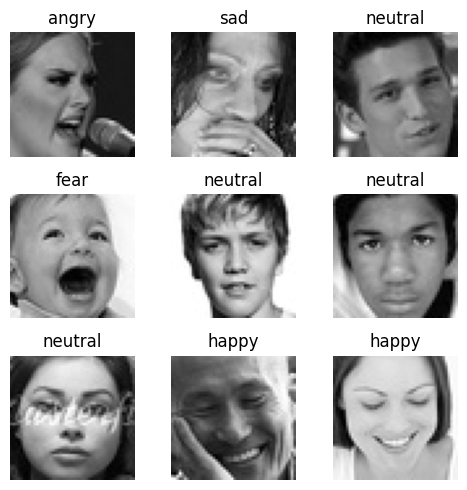

In [ ]:
# display random batch of images
imshow(images[:9], labels[:9], classes)

## Define Functions

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()    # set model to training mode
    total_loss = 0
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        # compute prediction and loss
        pred = model(images)
        loss = loss_fn(pred, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(images)
            print(f'loss: {loss:>7f}   [{current:>5d}/{size:>5d}]')

    average_train_loss = total_loss / len(dataloader)
    return average_train_loss

In [ ]:
def test_loop(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()    # set model to evaluation mode
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    average_test_loss = test_loss / num_batches
    accuracy = 100 * correct / size

    return average_test_loss, accuracy

In [ ]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on device: {device}.')

Training on device: cuda.


## Custom Basic CNN

In [ ]:
# define class that inherits from nn.Module base class
class CustomBasicCNN(nn.Module):
    def __init__(self):
        super(CustomBasicCNN, self).__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # fully connected layers
        self.fc1 = nn.Linear(64 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 7)

    def forward(self, x):
        # apply convolutional layers and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # flatten output for dense layers
        x = x.view(-1, 64 * 12 * 12)

        # apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on device: {device}.')

Training on device: cuda.


In [ ]:
# print architecture summary
summary(CustomBasicCNN().to(device), (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
         MaxPool2d-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Linear-5                  [-1, 256]       2,359,552
            Linear-6                    [-1, 7]           1,799
Total params: 2,380,167
Trainable params: 2,380,167
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.06
Params size (MB): 9.08
Estimated Total Size (MB): 10.15
----------------------------------------------------------------


In [ ]:
# initialization
model = CustomBasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# training and validation
num_epochs = 10
training_losses = []
validation_losses = []

# training loop
for epoch in range(num_epochs):
    print(-f'Epoch {epoch+1}\n------------------------------')

    train_loss = train_loop(train_loader, model, criterion, optimizer, device)
    val_loss, val_accuracy = test_loop(val_loader, model, criterion, device)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    print(f'Training Loss: {train_loss:.4f}, \
        Validation Loss: {val_loss:.4f}, \
        Validation Accuracy: {val_accuracy:.2f}%')

print('Done!')

Epoch 1
-------------------------------
loss: 1.949250   [    0/22968]
loss: 1.634989   [ 3200/22968]
loss: 1.551836   [ 6400/22968]
loss: 1.517159   [ 9600/22968]
loss: 1.353416   [12800/22968]
loss: 1.600709   [16000/22968]
loss: 1.520170   [19200/22968]
loss: 1.539578   [22400/22968]
Training Loss: 1.5570,         Validation Loss: 1.4293,         Validation Accuracy: 45.25%
Epoch 2
-------------------------------
loss: 1.507135   [    0/22968]
loss: 1.136501   [ 3200/22968]
loss: 1.547656   [ 6400/22968]
loss: 1.197315   [ 9600/22968]
loss: 1.588462   [12800/22968]
loss: 1.358317   [16000/22968]
loss: 1.248085   [19200/22968]
loss: 1.181576   [22400/22968]
Training Loss: 1.3161,         Validation Loss: 1.3545,         Validation Accuracy: 47.95%
Epoch 3
-------------------------------
loss: 1.318888   [    0/22968]
loss: 1.218111   [ 3200/22968]
loss: 0.933305   [ 6400/22968]
loss: 1.183935   [ 9600/22968]
loss: 0.891224   [12800/22968]
loss: 1.202794   [16000/22968]
loss: 1.260417

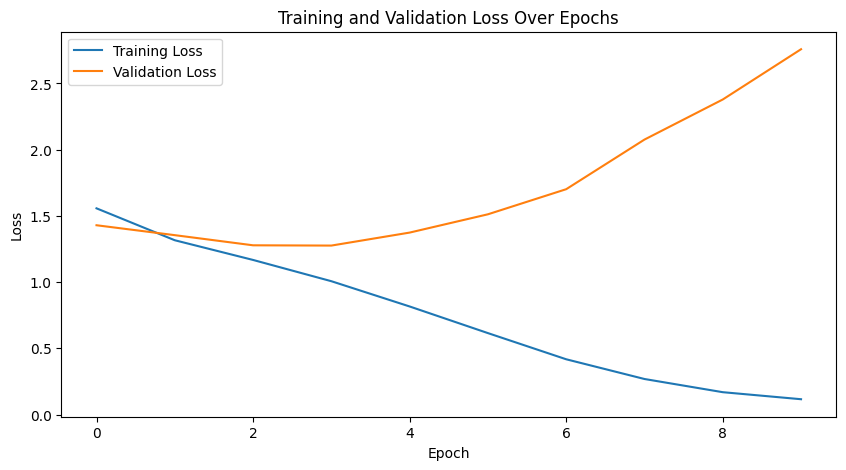

In [ ]:
# plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# test model on test data
print('Testing the model on test data\n-------------------------------')
test_loss, accuracy = test_loop(test_loader, model, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Testing the model on test data
-------------------------------
Test Loss: 2.6846, Test Accuracy: 51.84%


In [ ]:
# save model weights
model_weights_path = '/content/drive/MyDrive/colab_notebooks/computer_vision/project/model1_weights.pth'
torch.save(model.state_dict(), model_weights_path)

## Custom Advanced CNN

Inspired by 'An Efficient Approach to Face Emotion Recognition with Convolutional Neural Networks' (Białek et al., 2023).

In [ ]:
class CustomAdvancedCNN(nn.Module):
    def __init__(self):
        super(CustomAdvancedCNN, self).__init__()

        self.features = nn.Sequential(
            # first convolutional layer
            nn.Conv2d(1, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # second convolutional layer
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # third convolutional layer
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # fourth convolutional layer
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # fifth convolutional block
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 7),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on device: {device}.')

Training on device: cuda.


In [ ]:
summary(CustomAdvancedCNN().to(device), (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 48, 48]           1,280
       BatchNorm2d-2          [-1, 128, 48, 48]             256
              ReLU-3          [-1, 128, 48, 48]               0
         MaxPool2d-4          [-1, 128, 24, 24]               0
           Dropout-5          [-1, 128, 24, 24]               0
            Conv2d-6          [-1, 256, 24, 24]         295,168
       BatchNorm2d-7          [-1, 256, 24, 24]             512
              ReLU-8          [-1, 256, 24, 24]               0
         MaxPool2d-9          [-1, 256, 12, 12]               0
          Dropout-10          [-1, 256, 12, 12]               0
           Conv2d-11          [-1, 512, 12, 12]       1,180,160
      BatchNorm2d-12          [-1, 512, 12, 12]           1,024
             ReLU-13          [-1, 512, 12, 12]               0
        MaxPool2d-14            [-1, 51

In [ ]:
# initialization
model = CustomAdvancedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# training and validation
num_epochs = 30
training_losses = []
validation_losses = []

# training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')

    train_loss = train_loop(train_loader, model, criterion, optimizer, device)
    val_loss, val_accuracy = test_loop(val_loader, model, criterion, device)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    print(f'Training Loss: {train_loss:.4f}, \
        Validation Loss: {val_loss:.4f}, \
        Validation Accuracy: {val_accuracy:.2f}%')

print('Done!')

Epoch 1
-------------------------------
loss: 1.958754   [    0/22968]
loss: 1.876177   [ 3200/22968]
loss: 1.808097   [ 6400/22968]
loss: 1.844774   [ 9600/22968]
loss: 1.681511   [12800/22968]
loss: 1.665540   [16000/22968]
loss: 1.787145   [19200/22968]
loss: 1.768865   [22400/22968]
Training Loss: 1.7908,         Validation Loss: 1.7133,         Validation Accuracy: 44.19%
Epoch 2
-------------------------------
loss: 1.737008   [    0/22968]
loss: 1.766635   [ 3200/22968]
loss: 1.789048   [ 6400/22968]
loss: 1.671230   [ 9600/22968]
loss: 1.837565   [12800/22968]
loss: 1.780664   [16000/22968]
loss: 1.731584   [19200/22968]
loss: 1.672714   [22400/22968]
Training Loss: 1.7100,         Validation Loss: 1.6865,         Validation Accuracy: 46.47%
Epoch 3
-------------------------------
loss: 1.757736   [    0/22968]
loss: 1.742910   [ 3200/22968]
loss: 1.540255   [ 6400/22968]
loss: 1.830813   [ 9600/22968]
loss: 1.876167   [12800/22968]
loss: 1.546848   [16000/22968]
loss: 1.714688

In [ ]:
# save model weights
model_weights_path = '/content/drive/MyDrive/colab_notebooks/computer_vision/project/model2_weights.pth'
torch.save(model.state_dict(), model_weights_path)

In [ ]:
# additional training
additional_epochs = 10
for epoch in range(additional_epochs):
    print(f'Epoch {epoch+num_epochs+1}\n-------------------------------')

    train_loss = train_loop(train_loader, model, criterion, optimizer, device)
    val_loss, val_accuracy = test_loop(val_loader, model, criterion, device)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    print(f'Training Loss: {train_loss:.4f}, \
        Validation Loss: {val_loss:.4f}, \
        Validation Accuracy: {val_accuracy:.2f}%')

print('Done!')

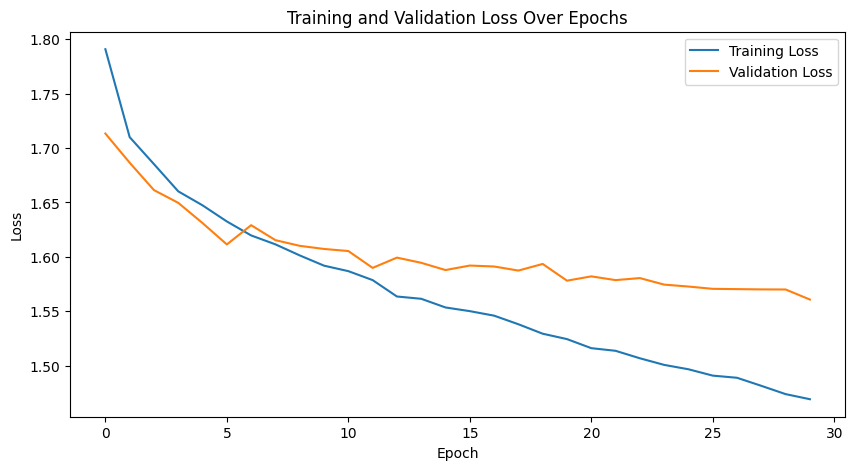

In [ ]:
# plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# test model on test data
print('Testing the model on test data\n-------------------------------')
test_loss, accuracy = test_loop(test_loader, model, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Testing the model on test data
-------------------------------
Test Loss: 1.5637, Test Accuracy: 59.84%


In [ ]:
# get predictions
def get_all_preds(model, loader, device):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    with torch.no_grad():
        for batch in loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

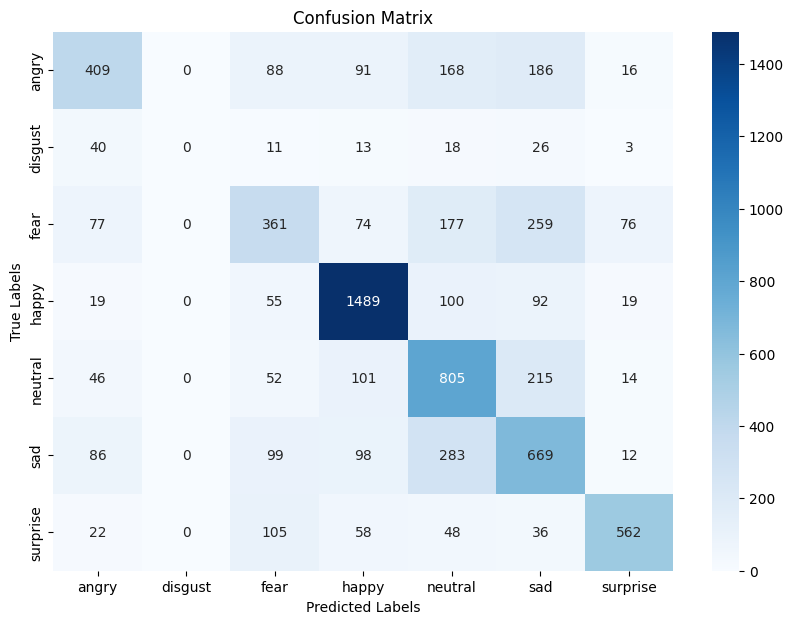

In [ ]:
model.eval()

# get predictions and labels from the test dataset
predictions, labels = get_all_preds(model, test_loader, device)
predicted_classes = predictions.argmax(dim=1)

# compute the confusion matrix
cm = confusion_matrix(labels.cpu(), predicted_classes.cpu())
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# save model weights
model_weights_path = '/content/drive/MyDrive/colab_notebooks/computer_vision/project/model2_weights.pth'
torch.save(model.state_dict(), model_weights_path)

## Transfer Learning CNN

ResNet50 trained on ImageNet.

In [ ]:
# load the pretrained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 126MB/s]


In [ ]:
# freeze the layers in feature extraction
for param in resnet50.parameters():
    param.requires_grad = False

In [ ]:
# replace the classifier of RestNet50
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_features, 2048),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048, 7),
    # nn.Softmax(dim=1)
)

In [ ]:
# data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# load datasets with updated transformations
train_dataset = datasets.ImageFolder(root=data_path + '/train',
                                     transform=transform)

test_dataset = datasets.ImageFolder(root=data_path + '/test',
                                    transform=transform)

In [ ]:
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for images, label in train_loader:
  print(images.shape)
  break

torch.Size([32, 3, 224, 224])


In [ ]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on device: {device}.')

Training on device: cuda.


In [ ]:
# initialization
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.0001)

In [ ]:
# training and validation
num_epochs = 30
training_losses = []
validation_losses = []

# training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')

    train_loss = train_loop(train_loader, resnet50, criterion, optimizer, device)
    val_loss, val_accuracy = test_loop(val_loader, resnet50, criterion, device)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    print(f'Training Loss: {train_loss:.4f}, \
        Validation Loss: {val_loss:.4f}, \
        Validation Accuracy: {val_accuracy:.2f}%')

print('Done!')

Epoch 1
-------------------------------
loss: 1.945735   [    0/22968]
loss: 1.801307   [ 3200/22968]
loss: 1.682514   [ 6400/22968]
loss: 1.608828   [ 9600/22968]
loss: 1.726771   [12800/22968]
loss: 1.755194   [16000/22968]
loss: 1.673227   [19200/22968]
loss: 1.892767   [22400/22968]
Training Loss: 1.6694,         Validation Loss: 1.5763,         Validation Accuracy: 38.48%
Epoch 2
-------------------------------
loss: 1.788756   [    0/22968]
loss: 1.672581   [ 3200/22968]
loss: 1.493367   [ 6400/22968]
loss: 1.608991   [ 9600/22968]
loss: 1.582167   [12800/22968]
loss: 1.443167   [16000/22968]
loss: 1.700326   [19200/22968]
loss: 1.456532   [22400/22968]
Training Loss: 1.5691,         Validation Loss: 1.5594,         Validation Accuracy: 39.30%
Epoch 3
-------------------------------
loss: 1.516908   [    0/22968]
loss: 1.496486   [ 3200/22968]
loss: 1.588484   [ 6400/22968]
loss: 1.587798   [ 9600/22968]
loss: 1.390571   [12800/22968]
loss: 1.365380   [16000/22968]
loss: 1.419399

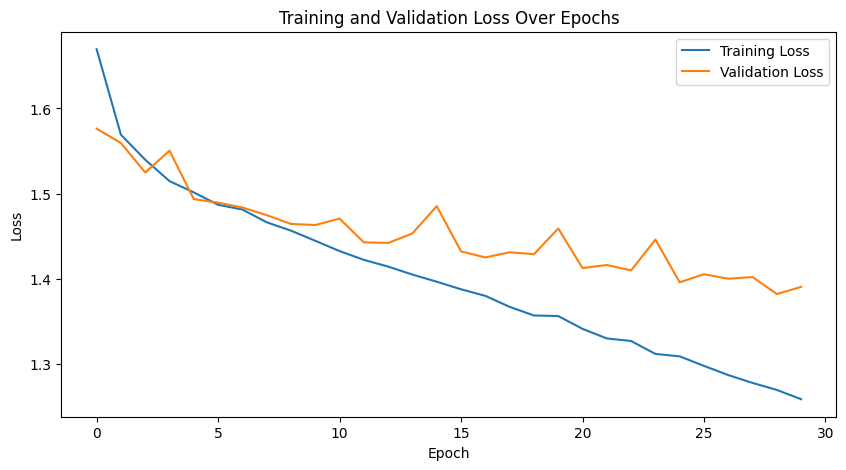

In [ ]:
# plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# test model on test data
print('Testing the model on test data\n-------------------------------')
test_loss, accuracy = test_loop(test_loader, resnet50, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Testing the model on test data
-------------------------------
Test Loss: 1.3745, Test Accuracy: 47.44%


In [ ]:
# save model weights
model_weights_path = '/content/drive/MyDrive/colab_notebooks/computer_vision/project/model3_weights.pth'
torch.save(resnet50.state_dict(), model_weights_path)

## Vision Transformer

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", model="dima806/facial_emotions_image_detection")

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("dima806/facial_emotions_image_detection")
model = AutoModelForImageClassification.from_pretrained("dima806/facial_emotions_image_detection")